In [39]:
import geopandas as gpd

In [40]:
roi = gpd.read_file('tehrant.shp')

In [41]:
roi.total_bounds

array([ 506999.4063, 3936167.    ,  554796.875 , 3965082.25  ])

In [42]:
minx, miny, maxx, maxy = roi.total_bounds 

In [43]:
import numpy as np
from shapely.geometry import Point 
def random_points_in_bound(minX, minY, maxX, maxY):
    x = np.random.uniform(minX, minY)
    y = np.random.uniform(minY, maxY)
    return Point(x,y)

In [44]:
numPoints = 100
randomPoints = []

In [45]:
while len(randomPoints) < numPoints:
    point = random_points_in_bound(minx,miny, maxx, maxy)
    if roi.contains(point).any():
        randomPoints.append(point)

In [46]:
randomPoints

[<POINT (528317.14 3951550.731)>,
 <POINT (545124.866 3955573.866)>,
 <POINT (535336.185 3943548.16)>,
 <POINT (518848.741 3953508.045)>,
 <POINT (537251.148 3958365.305)>,
 <POINT (543294.874 3956613.514)>,
 <POINT (543207.798 3946356.334)>,
 <POINT (510741.24 3955430.742)>,
 <POINT (545885.082 3957583.617)>,
 <POINT (538066.132 3957622.903)>,
 <POINT (529197.899 3942790.862)>,
 <POINT (532982.534 3953097.55)>,
 <POINT (542094.354 3942431.045)>,
 <POINT (524441.845 3950996.426)>,
 <POINT (516850.457 3957028.505)>,
 <POINT (546396.571 3954560.495)>,
 <POINT (533119.849 3944250.943)>,
 <POINT (537355.48 3960838.544)>,
 <POINT (546886.735 3957431.649)>,
 <POINT (549366.554 3954203.961)>,
 <POINT (536391.078 3950703.852)>,
 <POINT (531301.969 3953341.342)>,
 <POINT (551951.397 3956977.719)>,
 <POINT (537096.141 3943701.569)>,
 <POINT (524587.819 3964114.607)>,
 <POINT (538777.573 3947848.214)>,
 <POINT (542105.546 3960519.464)>,
 <POINT (547981.622 3953390.507)>,
 <POINT (536067.914 39602

<Axes: >

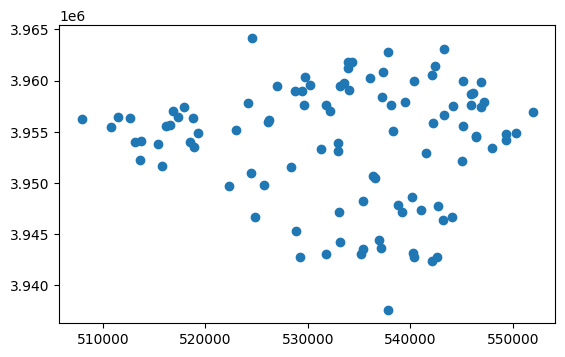

In [47]:
gdf = gpd.GeoDataFrame(geometry=randomPoints, crs=roi.crs)
gdf.plot()

In [48]:
import requests
URL = 'https://api.open-meteo.com/v1/forecast'
gdf = gdf.to_crs(epsg=4326)


In [49]:
for idx, point in gdf.iterrows():
        params = {
        'latitude': point.geometry.y,
        'longitude': point.geometry.x,
        'current': 'temperature_2m',
        'forecast_days': 1
    }
        response = requests.get(URL, params=params)
        if response.status_code == 200:
                  jsonData = response.json()
                  gdf.loc[idx, 'temper'] = jsonData['current']['temperature_2m']
                  gdf.loc[idx, 'ele'] = jsonData['elevation']
                  
 


In [50]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf.head()

,geometry,temper,ele,x,y
0,POINT (51.31304 35.70749),15.1,1218.0,51.313037,35.707490
1,POINT (51.49906 35.74314),14.8,1325.0,51.499062,35.743136
2,POINT (51.39028 35.63511),16.0,1100.0,51.390277,35.635110
3,POINT (51.20841 35.72536),14.6,1241.0,51.208414,35.725364
4,POINT (51.41211 35.76863),13.1,1476.0,51.412114,35.768633


In [51]:
gdf.drop('geometry', axis=1).corr()


,temper,ele,x,y
temper,1.000000,-0.946864,0.131079,-0.917565
ele,-0.946864,1.000000,0.157998,0.904912
x,0.131079,0.157998,1.000000,-0.055791
y,-0.917565,0.904912,-0.055791,1.000000


In [52]:
import folium


In [53]:
map = folium.Map(location=[35.6892, 51.3890], zoom_start=10)
for idx, point in gdf.iterrows():
    folium.Marker(
        location=[point.geometry.y, point.geometry.x],  
        popup='temperature: ' + str(point['temper']),
        icon=folium.Icon(color="red")
  
    ).add_to(map)

map


In [54]:
map = folium.Map(location=[35.6892, 51.3890], zoom_start=10, tiles='https://tile.openstreetmap.bzh/ca/{z}/{x}/{y}.png', attr='OSM')
for idx, point in gdf.iterrows():
    color = 'red' if point['temper'] > 14 else 'blue'
    folium.Marker(
        location=[point.geometry.y, point.geometry.x],  
        popup='temperature: ' + str(point['temper']),
        icon=folium.Icon(color=color)

  
    ).add_to(map)

map


In [55]:
from folium.plugins import MiniMap

minimap = MiniMap(toggle_display=True)
map.add_child(minimap)


In [56]:
from folium.plugins import HeatMap

map2 = folium.Map(location=[35.6, 51.3], zoom_start=10, tiles='https://tile.openstreetmap.org/{z}/{x}/{y}.png', attr='osm')

In [59]:
heatdata = [[point.geometry.y, point.geometry.x] for idx, point in gdf.iterrows()]
HeatMap(heatdata, radius=15).add_to(map2)
map2

In [57]:
heat_data = [[row.geometry.y, row.geometry.x] for _, row in gdf.iterrows()]
HeatMap(heat_data, radius=15).add_to(map2)
map2

In [63]:
from folium.plugins import MarkerCluster
map3 = folium.Map(location=[35.6, 51.3], zoom_start=10, tiles='https://tile.openstreetmap.org/{z}/{x}/{y}.png', attr='osm')
fg = MarkerCluster().add_to(map3)
map.save('fg.html')
